# Code for Question 2E

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(42)

In [2]:
class direhorse(Dataset):
    def __init__(self, file, normalize = True):
        super(direhorse, self).__init__()   # Calling parent class init function
        self.file = file                    
        self._init_dataset()                # Function to load the dataset and split into train and labels
        if normalize:                       # Normalise dataset function
            self._normalize_dataset()
            
    def _init_dataset(self):
        dataset = pd.read_csv(self.file) 
        self.train = torch.tensor(dataset['Ages'].values.astype('float32'))       
        self.labels = torch.tensor(dataset['Weights'].values.astype('float32'))
        
    def _normalize_dataset(self):
        self.train = F.normalize(self.train, dim = 0)
        
    def __getitem__(self, index):                       # Function to get the data point at the ith index
        return (self.train[index], self.labels[index])   
    
    def __len__(self):                                  # Function to get the length of the data
        return len(self.train)

In [3]:
class network(nn.Module):
    def __init__(self, hidden_layers = 1, units_per_layer = [8]):
        super(network, self).__init__()
        
        assert len(units_per_layer) == hidden_layers
        
        layers = []
        
        for i in range(hidden_layers):
            if i == 0:
                layers.append(nn.Linear(1, units_per_layer[i]))   # First layer definition
            else:
                layers.append(nn.Linear(units_per_layer[i-1], units_per_layer[i]))
            layers.append(nn.BatchNorm1d(units_per_layer[i]))     #Every layer is followed by a batchnorm and a relu activation
            layers.append(nn.ReLU())

        layers.append(nn.Linear(units_per_layer[-1], 1))          # Last Layer Definition
        
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        #print(x.shape)
        return self.layers(x)

In [4]:
def train(model, num_epochs, trainloader, valloader, loss_fn, optimiser, device):
    total_step = len(trainloader)
    train_loss_log = []
    val_loss_log = []
    
    for epoch in range(num_epochs):
        running_loss = 0
        model.train()
        print("------------------------------EPOCH: {} ------------------------".format(epoch+1))
        for i, (ages, weights) in enumerate(trainloader):
            ages = ages.to(device)
            weights = weights.to(device)
            
            ages = torch.unsqueeze(ages, dim = 1) 
            
            outputs = model(ages)
            outputs = torch.squeeze(outputs)
            
            train_loss = loss_fn(outputs, weights)
            running_loss += train_loss.item()
            
            optimiser.zero_grad()  # initialising gradients
            train_loss.backward()  # Compute all gradients
            optimiser.step()       # Take a single step of backprop
            
            if (i+1)%2 == 0:
                print('Epoch [{}/{}], Step [{}/{}], train_loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, train_loss.item()))
        
        train_loss_log.append(running_loss/total_step) 
        
        with torch.no_grad():
            model.eval()
            val_loss = 0
            
            for _, (ages, weights) in enumerate(valloader):
                ages = ages.to(device)
                weights = weights.to(device)
                ages = torch.unsqueeze(ages, dim = 1)
            
                outputs = model(ages)
                outputs = torch.squeeze(outputs)
                
                val_loss += loss_fn(outputs, weights).item()
            print("Val Loss: ", val_loss/len(valloader))
            if epoch!=0:
                if (val_loss/len(valloader)) < min(val_loss_log):
                    torch.save(model.state_dict(), 'direhorse_model.pth')

            val_loss_log.append(val_loss/len(valloader))
            
    return train_loss_log, val_loss_log

In [5]:
def plot_logs(train_logs, val_logs):
    plt.figure(figsize = (7,7))
    plt.plot(train_logs, label = 'Train Loss')
    plt.plot(val_logs, label = 'Validation Loss')
    plt.legend()
    plt.show()

In [39]:
epochs = 2000
hidden_layers = 2
units_per_layer = [8, 8]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Create dataloader
data = direhorse(file='direhorse.csv', normalize = False)

train_size = int(0.85*len(data))
val_size = len(data) - train_size

#Create validation split
trainset, valset = random_split(data, [train_size, val_size], torch.Generator().manual_seed(42))

trainloader = DataLoader(trainset, batch_size = 8)
valloader = DataLoader(valset, batch_size = 2)

# Defining model, loss and optimiser
model = network(hidden_layers=hidden_layers, units_per_layer=units_per_layer).to(device)
loss = nn.MSELoss().to(device)
optimiser = optim.Adam(model.parameters(), lr = 0.001)


In [40]:
train_log, val_log = train(model, epochs, trainloader, valloader, loss, optimiser, device)

------------------------------EPOCH: 1 ------------------------
Epoch [1/2000], Step [2/8], train_loss: 26581.3418
Epoch [1/2000], Step [4/8], train_loss: 15491.4434
Epoch [1/2000], Step [6/8], train_loss: 23213.9805
Epoch [1/2000], Step [8/8], train_loss: 18019.3633
Val Loss:  31339.741129557293
------------------------------EPOCH: 2 ------------------------
Epoch [2/2000], Step [2/8], train_loss: 26562.3750
Epoch [2/2000], Step [4/8], train_loss: 15477.5479
Epoch [2/2000], Step [6/8], train_loss: 23188.1406
Epoch [2/2000], Step [8/8], train_loss: 18003.7305
Val Loss:  31311.516031901043
------------------------------EPOCH: 3 ------------------------
Epoch [3/2000], Step [2/8], train_loss: 26545.6230
Epoch [3/2000], Step [4/8], train_loss: 15463.6621
Epoch [3/2000], Step [6/8], train_loss: 23158.3730
Epoch [3/2000], Step [8/8], train_loss: 17993.4980
Val Loss:  31290.935546875
------------------------------EPOCH: 4 ------------------------
Epoch [4/2000], Step [2/8], train_loss: 26529

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Streaming output truncated to the last 5000 lines.
Epoch [1167/2000], Step [8/8], train_loss: 280.9968
Val Loss:  218.7430183092753
------------------------------EPOCH: 1168 ------------------------
Epoch [1168/2000], Step [2/8], train_loss: 408.5361
Epoch [1168/2000], Step [4/8], train_loss: 604.6132
Epoch [1168/2000], Step [6/8], train_loss: 186.2787
Epoch [1168/2000], Step [8/8], train_loss: 280.7744
Val Loss:  375.63532225290936
------------------------------EPOCH: 1169 ------------------------
Epoch [1169/2000], Step [2/8], train_loss: 404.3271
Epoch [1169/2000], Step [4/8], train_loss: 615.2329
Epoch [1169/2000], Step [6/8], train_loss: 185.7355
Epoch [1169/2000], Step [8/8], train_loss: 281.0155
Val Loss:  257.15618483225506
------------------------------EPOCH: 1170 ------------------------
Epoch [1170/2000], Step [2/8], train_loss: 408.6881
Epoch [1170/2000], Step [4/8], train_loss: 603.0825
Epoch [1170/2000], Step [6/8], train_loss: 186.1258
Epoch [1170/2000], Step [8/8], trai

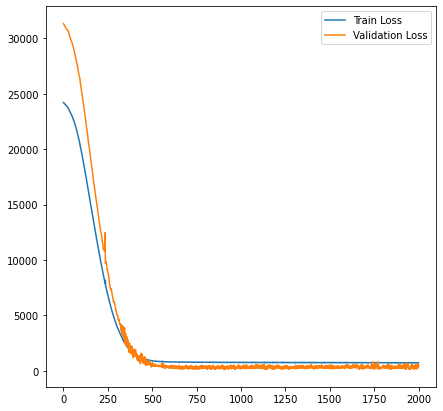

In [41]:
plot_logs(train_log, val_log)

In [42]:
## Comparison with function
mse = 0
for _, (ages, weights) in enumerate(valloader):
    y = 233.846*(1 - torch.exp(-1*0.006042*ages)) + 0.0001
    mse += nn.functional.mse_loss(y, weights).item()/len(valloader)

print(mse)

105.65359600385031
